## August 2nd Notes:
We shuffled the training and validation data before entering it into the ViT. We did this because of persistence in the input, where we got a very large r2 while training, and not after. 

However, the validation r2 we get while training now does not match the r2 on the validation we calculate outside of training. and we dont know WHYYYYYYYY.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import copy
import os

from einops import rearrange
from einops.layers.torch import Rearrange

import torch
import Simple_ViT.simple_vit as svit
import Simple_ViT.simple_vit_lrp as svitl

import importlib
# When you need to reload the module after an update
importlib.reload(svitl)



import getpass
myname = getpass.getuser()

import pandas as pd

## GPU Handling

In [2]:
def set_gpu(gpu_id):
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)
gpu_id=0

if gpu_id >= 0:
    device = "cuda"
    set_gpu(gpu_id)
    print('device available :', torch.cuda.is_available())
    print('device count: ', torch.cuda.device_count())
    print('current device: ',torch.cuda.current_device())
    print('device name: ',torch.cuda.get_device_name())
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
else:
    device = torch.device('cpu')

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

print('using device: ', device)

device available : True
device count:  1
current device:  0
device name:  NVIDIA A100-SXM4-80GB
NVIDIA A100-SXM4-80GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
using device:  cuda


## Load the Data

In [3]:
myname = 'wchapman'
dirout = f'/glade/derecho/scratch/{myname}/TOMSensoDS/'
# Check if the directory exists
if not os.path.exists(dirout):
    # Create the directory
    os.makedirs(dirout)
    print(f"Directory {dirout} created.")
else:
    print(f"Directory {dirout} already exists.")

DSmean_sst_anom = xr.open_dataset(os.path.join(dirout, 'SST_CESM2_PI.nc'))
print('...done loading SST...')

DSmean_trefht_anom_roll = xr.open_dataset(os.path.join(dirout, 'TREFHT_CESM2_PI.nc'))
print('...done loading TREFHT...')


DSmean_sst_anom['time'] = DSmean_trefht_anom_roll['time']

Directory /glade/derecho/scratch/wchapman/TOMSensoDS/ already exists.
...done loading SST...
...done loading TREFHT...


## Let's Lag this Bad Baby

In [4]:
lead_time = 30
DSmean_sst_anom_lag = DSmean_sst_anom.isel(time=slice(0,-lead_time))
DSmean_trefht_anom_roll_lag = DSmean_trefht_anom_roll.isel(time=slice(lead_time,len(DSmean_trefht_anom_roll['time'])))

##################################################
##### 1700 - 2000
##################################################

date_range = pd.date_range(start='1700-01-01', end='2000-01-01')
# Filter out February 29th
filtered_date_range = date_range[~((date_range.month == 2) & (date_range.day == 29))]\
# Display the filtered date range
end_date_300 = len(filtered_date_range)

print('...gather training...')
y_train = DSmean_trefht_anom_roll_lag.isel(time=slice(0,end_date_300-1))
y_train_anom = y_train.groupby('time.dayofyear') - y_train.groupby('time.dayofyear').mean()
x_train = DSmean_sst_anom_lag.isel(time=slice(0,end_date_300-1))
x_train_anom = x_train.groupby('time.dayofyear') - x_train.groupby('time.dayofyear').mean()

##################################################
##### 2000 - 2100
##################################################
date_range = pd.date_range(start='1700-01-01', end='2101-01-01')
# Filter out February 29th
filtered_date_range = date_range[~((date_range.month == 2) & (date_range.day == 29))]\
# Display the filtered date range
indy_val_s = int(np.where(filtered_date_range == '2000-01-01')[0])
indy_val_e = int(np.where(filtered_date_range == '2100-01-01')[0])

print('...gather validation...')
y_val = DSmean_trefht_anom_roll_lag.isel(time=slice(indy_val_s,indy_val_e))
y_val_anom = y_val.groupby('time.dayofyear') - y_val.groupby('time.dayofyear').mean()
x_val = DSmean_sst_anom_lag.isel(time=slice(indy_val_s,indy_val_e))
x_val_anom = x_val.groupby('time.dayofyear') - x_val.groupby('time.dayofyear').mean()

##################################################
##### 2000 - 2100
##################################################

date_range = pd.date_range(start='1700-01-01', end='2201-01-01')
# Filter out February 29th
filtered_date_range = date_range[~((date_range.month == 2) & (date_range.day == 29))]\
# Display the filtered date range
indy_test_s = int(np.where(filtered_date_range == '2100-01-01')[0])
indy_test_e = int(np.where(filtered_date_range == '2200-01-01')[0])

print('...gather testing...')
y_test = DSmean_trefht_anom_roll_lag.isel(time=slice(indy_test_s,indy_test_e))
y_test_anom = y_test.groupby('time.dayofyear') - y_test.groupby('time.dayofyear').mean()
x_test = DSmean_sst_anom_lag.isel(time=slice(indy_test_s,indy_test_e))
x_test_anom = x_test.groupby('time.dayofyear') - x_test.groupby('time.dayofyear').mean()

...gather training...
...gather validation...
...gather testing...


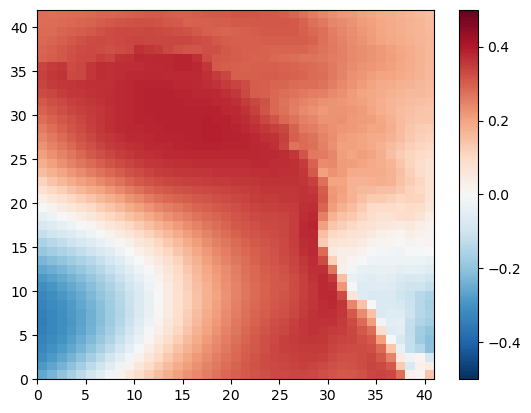

In [5]:
# Find a good location to predict
enso = x_train_anom['SST'].sel(lat=slice(-5,5),lon=slice(190,240)).mean(('lat','lon'))
nino = enso.where(enso >= 2, drop=True)

corrs = np.zeros(shape=(42,41))
for ilat in np.arange(0,len(y_train_anom['TREHT'].lat)):
    for ilon in np.arange(0,len(y_train_anom['TREHT'].lon)):
        corrs[ilat,ilon] = np.corrcoef(enso,y_train_anom['TREHT'][:, ilat, ilon])[0,1]

plt.pcolormesh(corrs,cmap='RdBu_r',vmin=-.5,vmax=.5)
plt.colorbar()

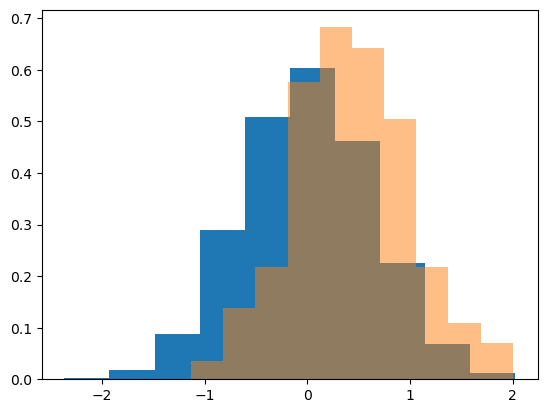

In [6]:
# Define & Check Predictand Point (do not delete this bad boy; vital for exsistence)
ilat = 10
ilon = 30
ynino = y_train_anom['TREHT'][:, ilat, ilon].sel(time=nino.time)
yall = y_train_anom['TREHT'][:, ilat, ilon]

plt.hist(yall,density=True)
plt.hist(ynino,density=True,alpha=0.5)
plt.show()

## Data Loader

In [7]:
class SpatialDataset(Dataset):
    def __init__(self, X, y):
        randi = np.random.choice(range(np.shape(X)[0]),size=np.shape(X)[0])
        self.X = torch.nan_to_num(torch.tensor(X[randi], dtype=torch.float32))
        self.y = torch.tensor(y[randi, ilat, ilon], dtype=torch.float32) #of the coast of CA
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx].unsqueeze(0), self.y[idx].unsqueeze(0)

## Model

In [8]:
batch_size = 64
input_shape = (1, 1, 192, 288) # Example input shape (C, H, W)

#(self, img_size=224, patch_size=16, in_chans=3, num_classes=1000, embed_dim=768, depth=12,num_heads=12, mlp_ratio=4., qkv_bias=False, mlp_head=False, drop_rate=0., attn_drop_rate=0.):

model = svitl.VisionTransformer(
        image_lr = 192,
        image_ud = 288,
        patch_size = 16,
        num_classes = 1,
        in_chans = 1,
        embed_dim = 3,
        depth = 2,
        num_heads = 3,
        mlp_ratio = 2.,
    ).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

train_dataset = SpatialDataset(np.array(x_train_anom['SST']), np.array(y_train_anom['TREHT']))
val_dataset = SpatialDataset(np.array(x_val_anom['SST']), np.array(y_val_anom['TREHT']))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## Train

In [9]:
num_epochs = 50
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    print(f"Starting Epoch {epoch}")
    nsampsseen = 0
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        nsampsseen += inputs.shape[0]
        if nsampsseen > 30000:
            break
    epoch_loss = running_loss / nsampsseen
    print(f"Epoch {epoch}, Loss: {epoch_loss:.4f}")

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    mse_val_batch=[]
    with torch.no_grad():  # In validation phase, we don't need to compute gradients
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs.to(device))
            mse_val_batch.append((torch.mean((outputs-labels)**2)))
    # Calculate and print validation accuracy
    mse_tot=torch.mean(torch.tensor(mse_val_batch))
    
    print(f"MSE: {mse_tot:.5f}")
    print( f"r2: {1-(mse_tot/np.var(y_val_anom['TREHT'][:, ilat, ilon]).values)}")
    
    if epoch == 0:
        print('...saved first epoch...')
        best_mod = copy.deepcopy(model)
        best_acc = copy.deepcopy(mse_tot)
    elif mse_tot<best_acc:
        print('...saving!...')
        best_mod = copy.deepcopy(model)
        best_acc = copy.deepcopy(mse_tot)
    else:
        print('No improvement in validation accuracy.')
    # Step the scheduler on each epoch
    scheduler.step(mse_tot)

Starting Epoch 0
Epoch 0, Loss: 0.3335
MSE: 0.32762
r2: 0.17894089221954346
...saved first epoch...
Starting Epoch 1
Epoch 1, Loss: 0.2886
MSE: 0.31992
r2: 0.19823849201202393
...saving!...
Starting Epoch 2
Epoch 2, Loss: 0.2687
MSE: 0.32320
r2: 0.19000035524368286
No improvement in validation accuracy.
Starting Epoch 3
Epoch 3, Loss: 0.2493
MSE: 0.30695
r2: 0.23074597120285034
...saving!...
Starting Epoch 4
Epoch 4, Loss: 0.2314
MSE: 0.30491
r2: 0.23584246635437012
...saving!...
Starting Epoch 5
Epoch 5, Loss: 0.2228
MSE: 0.29488
r2: 0.2609906792640686
...saving!...
Starting Epoch 6
Epoch 6, Loss: 0.2097
MSE: 0.28867
r2: 0.2765570878982544
...saving!...
Starting Epoch 7
Epoch 7, Loss: 0.2008
MSE: 0.28397
r2: 0.288338303565979
...saving!...
Starting Epoch 8
Epoch 8, Loss: 0.1968
MSE: 0.29706
r2: 0.25551384687423706
No improvement in validation accuracy.
Starting Epoch 9
Epoch 9, Loss: 0.1921
MSE: 0.27389
r2: 0.313585102558136
...saving!...
Starting Epoch 10
Epoch 10, Loss: 0.2027
MSE: 

In [92]:
Xval_check = torch.nan_to_num(torch.tensor(np.array(x_val_anom['SST']), dtype=torch.float32)).unsqueeze(0)
Xval_check_flipped = np.swapaxes(Xval_check,0,1)

pred = model(Xval_check_flipped[-1000:].to(device))
true = torch.tensor(np.array(y_val_anom['TREHT'][-1000:, ilat, ilon]), dtype=torch.float32)

mse = np.mean((pred.cpu().detach().numpy() - true.cpu().detach().numpy())**2)
print(mse) # this looks reasonable...
r2 = 1 - mse/np.var(true.cpu().detach().numpy())
print(r2) # WHY IS THIS NEGATIVE?? Should be close to 0.36

corr = np.corrcoef(pred.cpu().detach().numpy().squeeze(1),true.cpu().detach().numpy())
print(corr)

0.20044032
-0.8818492889404297
[[1.         0.28289845]
 [0.28289845 1.        ]]


In [91]:
# trying Tony idea to fit a linear model
true_std = (true.cpu().detach().numpy() - np.mean(true.cpu().detach().numpy(),axis=0))/np.std(true.cpu().detach().numpy(),axis=0)
pred_std = (pred.cpu().detach().numpy() - np.mean(pred.cpu().detach().numpy(),axis=0))/np.std(pred.cpu().detach().numpy(),axis=0)

pred_linear = 0.28*pred_std*np.std(pred.cpu().detach().numpy(),axis=0) + np.mean(true.cpu().detach().numpy(),axis=0)
1-(np.mean((pred_linear - true.cpu().detach().numpy())**2)/np.var(true.cpu().detach().numpy()))

-0.06910264492034912

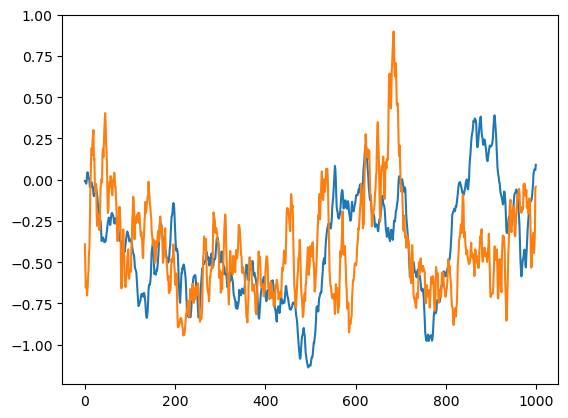

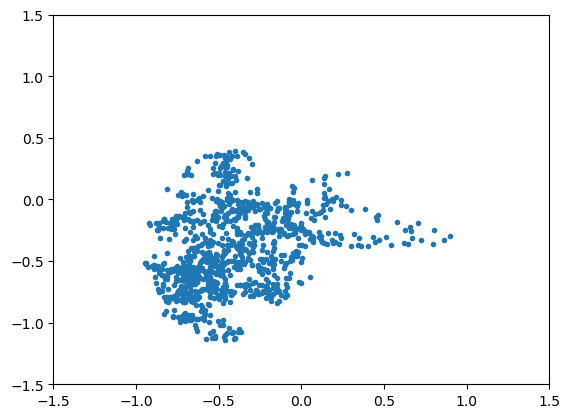

In [93]:
plt.plot(Yval_check.cpu().detach().numpy())
plt.plot(Xval_outputs.cpu().detach().numpy())
plt.show()

plt.plot(Xval_outputs.cpu().detach().numpy(),Yval_check.cpu().detach().numpy(),linewidth=0,marker='.')
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.show()

In [25]:
# import gc
# gc.collect()
# torch.cuda.empty_cache()